In [1]:
%load_ext autoreload

In [18]:
import pandas as pd
import numpy as np
import os
import feather
import matplotlib.pyplot as plt
from itertools import combinations
import copy

In [3]:
import sys
if "/proj/yunligrp/users/minzhi/utils/pylib" not in sys.path:
    sys.path.insert(0, "/proj/yunligrp/users/minzhi/utils/pylib")

In [60]:
from function_process_data_eqtl import *
from function_asso import *
from function_mesa_cca import *
%autoreload 2

### Loading Freeze8 Kinship Matrix for Later Usage

In [5]:
predata_dir = os.path.join("..", "prepro_data", "kinship")
freeze8_kinship_filename = "freeze8_kinship.feather"
freeze8_kinship_dir_filename = os.path.join(predata_dir, freeze8_kinship_filename)
%time freeze8_kinship_df = pd.read_feather(freeze8_kinship_dir_filename, use_threads = True)
freeze8_sample_list = list(freeze8_kinship_df)
freeze8_sample_df = pd.DataFrame(data=freeze8_sample_list, columns=["NWDID"])
freeze8_kinship_df_ID = pd.concat(objs=[freeze8_sample_df, freeze8_kinship_df], axis=1)

CPU times: user 2min 4s, sys: 6min 42s, total: 8min 46s
Wall time: 9min 46s


In [8]:
print(freeze8_kinship_df_ID.shape)

(140062, 140063)


## Scan All Cohorts

In [37]:
def table1(cohort, cn_var, cn_orig_dir):
    cn_orig_filename = "common_%s.tsv"%cn_var
#     cn_orig_dir = os.path.join("..", "cohort", cohort, "ready_data")
    cn_orig_dir_filename = os.path.join(cn_orig_dir, cn_orig_filename)
    cn_orig_df = pd.read_csv(cn_orig_dir_filename, sep="\t")
    if cn_var == "cn":
        cn_binary_df_full = cn2binary_df(cn_orig_df)
        cn_binary_df = cn_binary_df_full[["NWDID", "cn0", "cn1", "cn3", "cn4"]]
        cn_type_list = ["cn0", "cn1", "cn3", "cn4"]
        for cn_type in cn_type_list:
            cn_binary_df_move = move_cn(cn_binary_df, cn_type)
            cn_binary_df_move_filename = "common_cn-binary_%s.tsv"%cn_type
            cn_binary_df_move_dir_filename = os.path.join(cn_orig_dir, cn_binary_df_move_filename)
            cn_binary_df_move.to_csv(cn_binary_df_move_dir_filename, sep="\t", index=False)
    # to do: add the case of cn_var == "status"

In [38]:
def table2(cohort, gen_name, load_dir):
#     Load del
#     load_dir = os.path.join("..", "cohort", cohort, "ready_data")
    save_dir = load_dir
    del_cn_filename = "common_del.tsv"
    del_cn_dir_filename = os.path.join(load_dir, del_cn_filename)
    del_cn = pd.read_csv(del_cn_dir_filename, sep="\t", header = 0, index_col = None)
    
#     del x gen
    gen_filename = "common_%s.tsv"%gen_name
    gen_dir_filename = os.path.join(load_dir, gen_filename)
    gen = pd.read_csv(gen_dir_filename, sep="\t")
    common_col = "NWDID"
    del_gen = genxgen(del_cn, gen, "del", gen_name, common_col, save_dir)
    
#     Stratify gen by # del
    del_val_tuple = ([0], [1], [2])
    var_name = "del"
    for del_val_list in del_val_tuple:
        strati_gen(del_gen, del_val_list, var_name, gen_name, save_dir)

In [39]:
def strati_gen(var_gen, var_val_list, var_name, gen_name, save_dir):
    gen_var_val = var_gen.loc[var_gen.loc[:, var_name].isin(var_val_list), ["NWDID", gen_name]]
    var_val_name = "".join(map(str, var_val_list))
    gen_var_val_filename = "common_%s_%s%s.tsv"%(gen_name, var_name, var_val_name)
    gen_var_val_dir_filename = os.path.join(save_dir, gen_var_val_filename)
    gen_var_val.to_csv(gen_var_val_dir_filename, sep = "\t", header = True, index = False)

In [40]:
def table3(cohort, gen_name, table3_del_val_tuple, table3_cn_val_tuple, load_dir):
#     Load del and cn
#     load_dir = os.path.join("..", "cohort", cohort, "ready_data")
    save_dir = load_dir
    del_cn_filename = "common_del.tsv"
    del_cn_dir_filename = os.path.join(load_dir, del_cn_filename)
    del_cn = pd.read_csv(del_cn_dir_filename, sep="\t", header = 0, index_col = None)
    
    cn_filename = "common_cn.tsv"
    cn_dir_filename = os.path.join(load_dir, cn_filename)
    cn = pd.read_csv(cn_dir_filename, sep="\t", header = 0, index_col = None)
    
#     cn x gen, del x gen
    gen_filename = "common_%s.tsv"%gen_name
    gen_dir_filename = os.path.join(load_dir, gen_filename)
    gen = pd.read_csv(gen_dir_filename, sep="\t")
    common_col = "NWDID"
    cn_gen = genxgen(cn, gen, "cn", gen_name, common_col, save_dir)
    del_gen = genxgen(del_cn, gen, "del", gen_name, common_col, save_dir)
    
#     Stratify gen by # del
    var_name = "del"
    for del_val_list in table3_del_val_tuple:
        strati_gen(del_gen, del_val_list, var_name, gen_name, save_dir)
        
#     Stratify gen by # cn
    var_name = "cn"
    for cn_val_list in table3_cn_val_tuple:
        strati_gen(cn_gen, cn_val_list, var_name, gen_name, save_dir)

In [27]:
snp_ver = "freeze8"
snp_dir = os.path.join("..", "raw_data", "snp")
save_dir = os.path.join("..", "prepro_data", "snp")
snp_id_dict = {"rs334":"hetero", "rs33930165":"whole", "rs11248850":"whole"}
snp_col_list = [6, 6, 6]
snp_dir_filename_list = [os.path.join(snp_dir, "%s_%s.raw"%(snp_ver, snp_id)) for snp_id in snp_id_dict]
snp_df_list = save_snp_dict_each(snp_dir_filename_list, snp_id_dict, snp_ver, save_dir, snp_col_list)

/proj/yunligrp/users/minzhi/utils/pylib/function_process_data_eqtl.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snp_df.dropna(axis = 0, how = "any", inplace = True)


### Splitting phenotypes to each cohort

In [54]:
pheno_dir = os.path.join("..", "prepro_data", "phenotype")
pheno_filename = "freeze8_anno05_af02_btc03-coh04_egfr03-ckd_adad01_race_ethnicity_0-2.tsv"
pheno_dir_filename = os.path.join(pheno_dir, pheno_filename)
pheno = pd.read_csv(pheno_dir_filename, sep = "\t", header = 0, index_col = None)

In [55]:
status = "cn"
anno = pheno
df = pheno
cat_col = "study"
anno_merge_col_list = ["NWDID"]
df_merge_col_list = ["NWDID"]
all_cohorts = True
save_filename_prefix = "freeze8_anno05_af02_btc03-coh04_egfr03-ckd_adad01_race_ethnicity_0-2"
save_dir_root = os.path.join("..", status)
save_dir_base = "pre_data"
cohort_list = df_splitter(anno, df, cat_col, anno_merge_col_list, df_merge_col_list,
                          all_cohorts, save_filename_prefix, save_dir_root, save_dir_base)

### Preparing Common Sample Data

In [56]:
pheno_prefix = "freeze8_anno05_af02_btc03-coh04_egfr03-ckd_adad01_race_ethnicity_0-2"
full_pheno_dir = os.path.join("..", "prepro_data", "phenotype")
full_pheno_filename = f"{pheno_prefix}.tsv"
full_pheno_dir_filename = os.path.join(full_pheno_dir, full_pheno_filename)
full_pheno = pd.read_csv(full_pheno_dir_filename, sep = "\t", header = 0, index_col = None)
_, cohort_list = categorize_df(full_pheno, "study")
print(cohort_list)

status_name = "cn"
freeze_ver = "freeze8"
pc_num = 11
common_col = "NWDID"
# snp_id_dict_list = [{"rs334":"hetero"}, {"rs33930165":"whole"}, {"rs11248850":"whole"}]
snp_id_dict_list = [{"rs334":"hetero", "rs33930165":"whole", "rs11248850":"whole"}]

for cohort in cohort_list:
    pheno_filename = "%s_%s.tsv"%(pheno_prefix, cohort)
    status_filename = "%s_%s.tsv"%(status_name, cohort)
    for snp_id_dict in snp_id_dict_list:
        snp_list = list(snp_id_dict.keys())
        snp_id_string = "_".join(snp_list)
        save_dir = os.path.join("..", status_name, cohort, "ready_data_%s"%snp_id_string)
        snp_filename_list = []
        for snp_id in snp_id_dict:
            snp_type = snp_id_dict[snp_id]
            snp_filename = "%s_%s_%s.tsv"%(freeze_ver, snp_id, snp_type)
            snp_filename_list.append(snp_filename)
        common_gene_status_pc_pheno_kinship(status_name, cohort, freeze_ver, pc_num, common_col, freeze8_kinship_df_ID,
                                            snp_filename_list, snp_list, pheno_filename, status_filename, save_dir)
        print("%s common samples found."%cohort)

['HyperGEN', 'GeneSTAR', 'WHI', 'CHS', 'SAFS', 'DHS', 'GENOA', 'CARDIA', 'BioMe', 'COPDGene', 'ARIC', 'MESA', 'HCHS_SOL', 'JHS']
(1784, 1785)
HyperGEN common samples found.
(692, 693)
GeneSTAR common samples found.
(1427, 1428)
WHI common samples found.
(678, 679)
CHS common samples found.
(1107, 1108)
SAFS common samples found.
(372, 373)
DHS common samples found.
(1057, 1058)
GENOA common samples found.
(1354, 1355)
CARDIA common samples found.
(5444, 5445)
BioMe common samples found.
(1592, 1593)
COPDGene common samples found.
(226, 227)
ARIC common samples found.
(2105, 2106)
MESA common samples found.
(3847, 3848)
HCHS_SOL common samples found.
(3096, 3097)
JHS common samples found.


### Preparing Data for Each Table

In [61]:
pheno_prefix = "freeze8_anno05_af02_btc03-coh04_egfr03-ckd_adad01_race_ethnicity_0-2"
full_pheno_dir = os.path.join("..", "prepro_data", "phenotype")
full_pheno_filename = f"{pheno_prefix}.tsv"
full_pheno_dir_filename = os.path.join(full_pheno_dir, full_pheno_filename)
full_pheno = pd.read_csv(full_pheno_dir_filename, sep = "\t", header = 0, index_col = None)
_, cohort_list = categorize_df(full_pheno, "study")

# cohort_list = ["WHI"]

status_name = "cn"
common_col = "NWDID"
snp_id_dict_list = [{"rs334":"hetero", "rs33930165":"whole", "rs11248850":"whole"}, {"rs334":"hetero", "rs33930165":"whole", "rs11248850":"whole"},
                    {"rs334":"hetero", "rs33930165":"whole", "rs11248850":"whole"}]

phenotype_list = ["hemoglobin_mcnc_bld_1", "hematocrit_vfr_bld_1", "rbc_ncnc_bld_1", "DDIMER",
                  "mcv_entvol_rbc_1", "mch_entmass_rbc_1", "mchc_mcnc_rbc_1", "rdw_ratio_rbc_1",
                  "neutrophil_ncnc_bld_1", "lymphocyte_ncnc_bld_1", "basophil_ncnc_bld_1",
                  "eosinophil_ncnc_bld_1", "monocyte_ncnc_bld_1", "wbc_ncnc_bld_1", "lnHBA1C", 
                  "pmv_entvol_bld_1", "platelet_ncnc_bld_1", "EGFRCKDEPI", "CKD", "microcytosis", "anemia"]
table_dict_list = [{"table1":["cn-binary_cn0", "cn-binary_cn1", "cn-binary_cn3", "cn-binary_cn4", "rs334", "rs33930165"]},
                   {"table2":["rs334_del0", "rs334_del1", "rs334_del2", "del-rs334"]},
                   {"table3":["rs11248850", "rs11248850_del0", "rs11248850_del12", "rs11248850_cn2", "rs11248850_cn34", "del-rs11248850"]}
                  ]
adad_dict = {"quan":["WEIGHT_FINAL_NORM_OVERALL"], "cati":["gengrp6", "CENTER", "AA", "ethnicity"]}

gen_name_1 = "rs334"
gen_name_2 = "rs33930165"
gen_name_3 = "rs11248850"
table3_del_val_tuple = ([0], [1, 2])
table3_cn_val_tuple = ([2], [3, 4])

for cohort in cohort_list:
    for table_dict, snp_id_dict in zip(table_dict_list, snp_id_dict_list):
        snp_id_list = list(snp_id_dict.keys())
        snp_id_string = "_".join(snp_id_list)
        
        load_dir = os.path.join("..", status_name, cohort, "ready_data_%s"%snp_id_string)
        table_name = list(table_dict.keys())[0]
        if table_name == "table1":
            table1(cohort, status_name, load_dir)
        elif table_name == "table2":
            table2(cohort, gen_name_1, load_dir)
        elif table_name == "table3":
            table3(cohort, gen_name_3, table3_del_val_tuple, table3_cn_val_tuple, load_dir)
        wrap_prepare_matrix_pheno_adad_in_pheno(status_name, cohort, phenotype_list, table_dict, load_dir, adad_dict)
    print("%s completed."%cohort)

table1 completed.
table2 completed.
table3 completed.
HyperGEN completed.
table1 completed.
table2 completed.
table3 completed.
GeneSTAR completed.
table1 completed.
table2 completed.
table3 completed.
WHI completed.
table1 completed.
table2 completed.
table3 completed.
CHS completed.
table1 completed.
table2 completed.
table3 completed.
SAFS completed.
table1 completed.
table2 completed.
table3 completed.
DHS completed.
table1 completed.
table2 completed.
table3 completed.
GENOA completed.
table1 completed.
table2 completed.
table3 completed.
CARDIA completed.
table1 completed.
table2 completed.
table3 completed.
BioMe completed.
table1 completed.
table2 completed.
table3 completed.
COPDGene completed.
table1 completed.
table2 completed.
table3 completed.
ARIC completed.
table1 completed.
table2 completed.
table3 completed.
MESA completed.
table1 completed.
table2 completed.
table3 completed.
HCHS_SOL completed.
table1 completed.
table2 completed.
table3 completed.
JHS completed.


### Apply MESA (from Methylation) Samples to Kinship Matrix

In [23]:
save_dir = "/pine/scr/m/i/minzhi/mesa_multiomics/methylation_normalized"
sample_filename = "TOPMed_MESA.methylomics.samplesheet_with_feno.mixup_fix.only_BIS.pass_QC.txt"
sample_dir_filename = os.path.join(save_dir, sample_filename)
sample_df_raw = pd.read_csv(sample_dir_filename, sep="\t")
print(sample_df_raw.shape)
sample_df = sample_df_raw[["NWDID"]]
kinship_sample_selected = kinship_select_sample(freeze8_kinship_df_ID, sample_df)
print(kinship_sample_selected.shape)

(1890, 21)
(1890, 1891)


In [39]:
sample_df_unique = sample_df.drop_duplicates(subset ="NWDID", keep = "first", inplace = False)
kinship_sample_unique_selected = kinship_select_sample(freeze8_kinship_df_ID, sample_df_unique)
print(kinship_sample_unique_selected.shape)

(936, 937)


In [52]:
unrelated_dir = "/pine/scr/m/i/minzhi/mesa_multiomics/methylation_normalized"
unrelated_filename = "TOPMed_MESA.1331_samples_unrelated.txt"
unrelated_dir_filename = os.path.join(unrelated_dir, unrelated_filename)
unrelated = pd.read_csv(unrelated_dir_filename, sep = "\t", header = None, index_col = None)
unrelated.rename(columns = {0:"NWDID"}, inplace = True)
overlap_unrelated_methy = sample_df_unique.merge(unrelated, on = "NWDID", how = "inner")
print(overlap_unrelated_methy.shape)

(906, 1)


In [42]:
common_kinship_filename = "mesa_methy_kinship_unique.tsv"
common_kinship_dir_filename = os.path.join(save_dir, common_kinship_filename)
kinship_sample_unique_selected.to_csv(common_kinship_dir_filename, sep="\t", index=False)

In [44]:
common_kinship_filename = "mesa_methy_kinship_unique.tsv"
common_kinship_dir_filename = os.path.join(save_dir, common_kinship_filename)
kinship_sample_unique_selected_IDidx = pd.read_csv(common_kinship_dir_filename, sep="\t", index_col=0, header = 0)

In [45]:
def kinship_filtering(kinship_matrix, thres):
	original_list = list(kinship_matrix.columns)
	sample_num = len(original_list)
	correlated_sample_index = []
	uncorrelation_sample_list = []
	for sample_i in range(1, sample_num):
		for ortho_sample_i in range(sample_i):
			if kinship_matrix.iloc[sample_i, ortho_sample_i] > thres:
				correlated_sample_index.append(ortho_sample_i)
	for sample_i in range(sample_num):
		if sample_i not in correlated_sample_index:
			uncorrelation_sample_list.append(original_list[sample_i])
	return uncorrelation_sample_list

In [48]:
thres_list = [1, 0.2, 0.1, 0.05, 0.03125, 0.025, 0.005]
for thres in thres_list:
    uncorrelation_sample_list = kinship_filtering(kinship_sample_unique_selected_IDidx, thres)
    print(len(uncorrelation_sample_list))

936
925
917
912
910
905
629


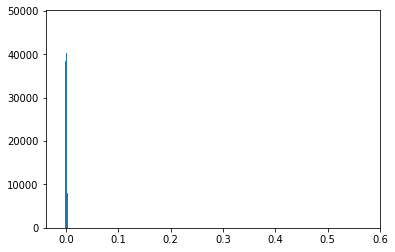

In [34]:
kinship_sample_selected_noID = kinship_sample_selected.drop(axis = 1, labels = "NWDID")
kinship_sample_selected_noID_array = kinship_sample_selected_noID.values
inds = np.tril_indices(kinship_sample_selected_noID_array.shape[0], -1) 
vals = kinship_sample_selected_noID_array[inds]
_ = plt.hist(vals, bins='auto')

In [36]:
thres_list = [0.2, 0.1, 0.05, 0.03125, 0.025, 0.005]
print(vals.shape)
for thres in thres_list:
    tmp_vals = vals[vals <= thres]
    tmp_sample_num = len(tmp_vals)
    print(tmp_sample_num)

(1785105,)
1784083
1784041
1784015
1783993
1783967
1781725


# Association between Blood Cell Trait and SOL

## Preprocess Data

### Phenotype

In [27]:
cohort = "SOL"
save_dir = os.path.join("..", "cohort", cohort, "pre_data")
pheno_filename = "pheno_%s.tsv"%cohort
common_pheno_anno_cn_egfr = pheno_prep(cohort, egfr_df, anno_df, pheno_df)
pheno_wckd_wmicrocytosis_anemia_df = pheno_adding_features_recode_sex(common_pheno_anno_cn_egfr, save_dir, pheno_filename)

#### D-Dimer

In [150]:
ddmier_filename = "TOPMED_HarmonizedPhenotypes_DDIMER_21MAY2019.csv"
ddmier_dir = os.path.join("..", "raw_data", "phenotype")
ddmier_dir_filename = os.path.join(ddmier_dir, ddmier_filename)
ddmier = pd.read_csv(ddmier_dir_filename, sep = ",", header = 0, index_col = None)
ddmier_selected = ddmier[["sample.id", "sample_remove_DDIMER", "DDIMER", "AGE_DDIMER"]] #, "study_race", "sex"
ddmier_selected.rename(columns={"sample.id":"NWDID", "AGE_DDIMER":"age_at_DDIMER"}, inplace=True)
ddmier_selected_filename = "SOL_ddimer.tsv"
ddmier_selected_dir = os.path.join("..", "prepro_data", "phenotype")
ddmier_selected_dir_filename = os.path.join(ddmier_selected_dir, ddmier_selected_filename)
ddmier_selected.to_csv(ddmier_selected_dir_filename, sep = "\t", header = True, index = False)

#### Gengrp6
After testing, to each sample, if s/he has non-NaN SUBJECT_ID and gengrp6 value, then it must have non-NaN CONSENT_text and INTERNAL_USE_ONLY value.

In [151]:
gengrp6_filename = "page-harmonized-phenotypes-pca-freeze2-candidate2-2016-12-14.GWASid_fid_22May2018internalPCs.SOLv2consent.txt"
gengrp6_dir = os.path.join("..", "raw_data", "adjustment", "gengrp6")
gengrp6_dir_filename = os.path.join(gengrp6_dir, gengrp6_filename)
gengrp6 = pd.read_csv(gengrp6_dir_filename, sep = "\t", header = 0, index_col = None)
gengrp6.replace(".", np.nan, inplace=True)
gengrp6_select = gengrp6[["z_sol_id", "analysis_id", "CONSENT_text", "INTERNAL_USE_ONLY",
                          "gengrp6"]].dropna(axis=0, subset=["analysis_id","gengrp6"],how="any")
gengrp6_select.rename(columns = {"analysis_id":"SUBJECT_ID"}, inplace=True)

#### Weight & Center

In [173]:
weight_center_dir = os.path.join("..", "raw_data", "adjustment")
weight_center_filename = "bloodcell_output.csv"
weight_center_dir_filename = os.path.join(weight_center_dir, weight_center_filename)
weight_center = pd.read_csv(weight_center_dir_filename, sep = ",", header = 0, index_col = None)
weight_center_select = weight_center[["ID", "WEIGHT_FINAL_NORM_OVERALL", "CENTER"]].dropna(axis = 0, how = "any")
weight_center_select.rename(columns = {"ID":"z_sol_id"}, inplace = True)

#### Merging Weight & Center Table with Gengrp6 Table

In [153]:
common_col = "z_sol_id"
gengrp6_weight_center_list = [gengrp6_select, weight_center_select]
gengrp6_weight_center = merge_df_list(gengrp6_weight_center_list, common_col, merge_method='merge', how = 'inner')
gengrp6_weight_center.drop(axis = 1, columns = ["z_sol_id"], inplace = True)
gengrp6_weight_center_filename = "SOL_gengrp6_weight_center.tsv"
gengrp6_weight_center_dir = os.path.join("..", "prepro_data", "phenotype")
gengrp6_weight_center_dir_filename = os.path.join(gengrp6_weight_center_dir, gengrp6_weight_center_filename)
gengrp6_weight_center.to_csv(gengrp6_weight_center_dir_filename, sep = "\t", header = True, index = False)

#### Merging Weight, Center, Gengrp6 and D-Dimer into Phenotype Table

In [35]:
gengrp6_weight_center_filename = "SOL_gengrp6_weight_center.tsv"
gengrp6_weight_center_dir = os.path.join("..", "prepro_data", "phenotype")
gengrp6_weight_center_dir_filename = os.path.join(gengrp6_weight_center_dir, gengrp6_weight_center_filename)
gengrp6_weight_center = pd.read_csv(gengrp6_weight_center_dir_filename, sep = "\t", header = 0, index_col = None)
#display(gengrp6_weight_center)

ddimer_filename = "SOL_ddimer.tsv"
ddimer_dir = os.path.join("..", "prepro_data", "phenotype")
ddimer_dir_filename = os.path.join(ddimer_dir, ddimer_filename)
ddimer = pd.read_csv(ddimer_dir_filename, sep = "\t", header = 0, index_col = None)
#display(ddimer)

common_col = "SUBJECT_ID"
pheno_gengrp6_weight_center_list = [pheno_wckd_wmicrocytosis_anemia_df, gengrp6_weight_center]
pheno_gengrp6_weight_center = merge_df_list(pheno_gengrp6_weight_center_list, common_col, merge_method='merge', how = 'outer')

common_col = "NWDID"
pheno_gengrp6_weight_center_ddimer_list = [pheno_gengrp6_weight_center, ddimer]
pheno_gengrp6_weight_center_ddimer = merge_df_list(pheno_gengrp6_weight_center_ddimer_list, common_col, merge_method='merge', how = 'outer')
#display(pheno_gengrp6_weight_center_ddimer)

pheno_gengrp6_weight_center_ddimer.dropna(axis = 0, subset = ["NWDID"], inplace = True)
pheno_gengrp6_weight_center_ddimer = pheno_gengrp6_weight_center_ddimer[pheno_gengrp6_weight_center_ddimer["CONSENT_text"] != "DROP"]
pheno_gengrp6_weight_center_ddimer = pheno_gengrp6_weight_center_ddimer[pheno_gengrp6_weight_center_ddimer["sample_remove_DDIMER"] != 1]

add_adj_dict = {"quant":["WEIGHT_FINAL_NORM_OVERALL"],"cati":["gengrp6", "CENTER"]}
pheno_gengrp6_weight_center_ddimer_dummy_adj, add_adj_list = cati2dummy_df(pheno_gengrp6_weight_center_ddimer, add_adj_dict)



In [ ]:
save_dir = os.path.join("..", "cohort", cohort, "pre_data")
pheno_filename = "pheno_%s_20190904.tsv"%cohort
pheno_dir_filename = os.path.join(save_dir, pheno_filename)
pheno_gengrp6_weight_center_ddimer.to_csv(pheno_dir_filename, sep = "\t", header = True, index = False)

In [42]:
cohort = "SOL"
cn_filename = "%s_cn.tsv"%cohort
cn_dir = os.path.join("..", "cohort", cohort, "cn")
cn_dir_filename = os.path.join(cn_dir, cn_filename)
cn_df = pd.read_csv(cn_dir_filename, sep = "\t", header = 0, index_col = None)

In [53]:
ddmier_filename = "TOPMED_HarmonizedPhenotypes_DDIMER_21MAY2019.csv"
ddmier_dir = os.path.join("..", "raw_data", "phenotype")
ddmier_dir_filename = os.path.join(ddmier_dir, ddmier_filename)
ddmier = pd.read_csv(ddmier_dir_filename, sep = ",", header = 0, index_col = None)

In [43]:
common_col = "NWDID"
cn_df_ddimer_list = [cn_df, ddimer]
cn_df_ddimer_inner = merge_df_list(cn_df_ddimer_list, common_col, merge_method='merge', how = 'inner')

In [54]:
a = cn_df.merge(ddmier, left_on="NWDID", right_on="sample.id")
display(a)

,NWDID,CN,sample.id,unique_subject_key,unique_subject_key_f6a,flag_diff_USK_F8_f6a,subject_id,topmed_project,topmed_phase,funding,...,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,study


In [96]:
print(duplicates_num(pheno_gengrp6_weight_center_ddimer, "NWDID"))

0
